## TP Climate Finance

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp

Importing data

---

In [2]:
df_stock=pd.read_excel("Individual_stock_data.xlsx",sheet_name='stock prices').dropna(axis=1)
df_stock=df_stock.set_index('Date')
df_stock.index=pd.to_datetime(df_stock.index)
df_carbonfootprint=pd.read_excel("Individual_stock_data.xlsx",sheet_name='carbon footprint data',skiprows=20,nrows=1,
names=['NAME','SECTOR','SECTOR_NAME','SCOPE1','SCOPE2','EMISSIONS','MARKET_VALUE','REVENUES','CARBON_FOOTPRINT','INTENSITY'])
df_sp=pd.read_excel('Individual_stock_data.xlsx',sheet_name='SP500')
df_sp=df_sp.set_index('Name')

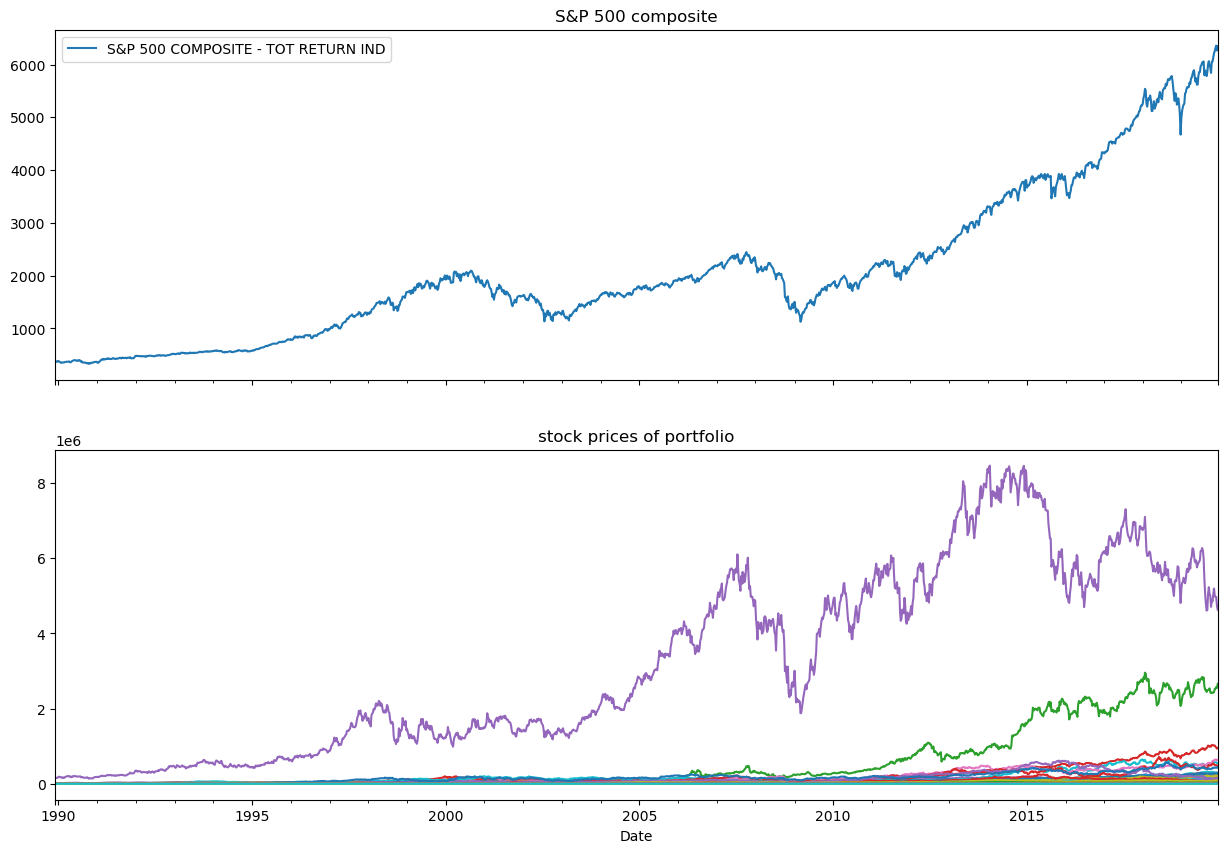

In [38]:
fig,ax=plt.subplots(2,1,figsize=(15,10),sharex=True)
df_sp.plot(ax=ax[0], title='S&P 500 composite')
df_stock.plot(ax=ax[1],legend=False,title='stock prices of portfolio')
plt.show()

Weight search by minimizing tracking error

---

In [4]:
def add_return(df):
    iduree=[i for i in range(len(df_stock.index))]
    del iduree[0]                                                              #we exclude the 1st time
    df=df.copy()
    columns=[f'Return {c}' for c in df_stock.columns]
    dfr=pd.DataFrame(np.zeros((len(df.index),len(columns))),columns=columns)   #construction of a dataframe named "dfr" filled with zeros that will contain the values of the returns
    for c in df.columns :
        for i in iduree :
            dfr.loc[i,f'Return {c}']=(df.loc[df.index[i],c]-df.loc[df.index[i]-np.timedelta64(7, 'D'),c])/df.loc[df.index[i],c] #computation of the values of the returns
        dfr.loc[0,f'Return {c}']=0                                             #set to zero the values of the returns for the first instant
    dfr.index=df.index
    return pd.concat([df,dfr],axis=1)                                          #Return the concatenation of the initial dataframe "df" and "dfr" which contains the calculated values

Computation of returns for each corp

In [5]:
df_stock=add_return(df_stock)

Division of the time horizon (3 years)

In [6]:
intervalle0=df_stock.index[(df_stock.index < '1993-01-01')]
T=len(intervalle0)
NbT=int(len(df_stock)/T)+1

Dynamic time interval

In [7]:
def Intervalle(i):
    I=df_stock.index[(df_stock.index < '1993-01-01')]
    if i==10:
        I=df_stock.index[(df_stock.index > Intervalle(9).max())]
    if 0<i<NbT:
        I=df_stock.index[(df_stock.index > Intervalle(i-1).max())&(df_stock.index < Intervalle(i-1).max()+np.timedelta64(T, 'W'))]
    return I

Optimization

In [33]:
#weights for each corporation
lw=[]
a=0
weights={}
for c in df_stock.columns[int(len(df_stock.columns)/2):]:
    for i in range(NbT):
        model=gp.Model()
        model.Params.LogToConsole = 0
        w=model.addVar(vtype=gp.GRB.CONTINUOUS)
        
        model.setObjective(gp.quicksum(w*df_stock.loc[t,c]-df_sp.loc[t,:] for t in Intervalle(i))**2/T,gp.GRB.MINIMIZE)
        model.update()
        model.optimize()
        lw.append(w.x)
    weights[c[7:]]=lw[a:]
    a+=10

In [37]:
dfweights=pd.DataFrame(weights)
dfweights.head(10)

,AAPL,MSFT,JPM,JNJ,WMT,BAC,PG,XOM,DIS,T,...,LEG,NWL,JWN,PNR,PBCT,RHI,SEE,FLS,HP,UNM
0,2.552015e+06,5.376945e+04,1.111816e+06,1.291890e+05,7.145995e+04,1.457127e+06,1.395916e+05,1.900922e+05,3.413796e+05,2.256974e+05,...,9.221780e+04,1.335551e+05,0.000000e+00,182239.270183,0.000000e+00,0.000000e+00,9.080918e+04,210669.028199,0.000000e+00,1.029634e+05
1,0.000000e+00,1.662037e+05,2.055002e+05,1.739411e+05,0.000000e+00,3.539347e+05,1.979446e+05,2.788092e+05,3.648671e+05,2.052316e+05,...,5.131660e+05,5.185278e+05,0.000000e+00,163538.216180,9.028052e+04,6.077451e+04,1.280415e+05,491837.275784,9.834993e+05,1.839686e+06
2,0.000000e+00,1.079545e+05,2.324733e+05,2.993987e+05,1.405252e+05,3.363141e+05,2.792137e+05,3.238245e+05,4.312448e+05,3.168970e+05,...,3.536823e+05,3.940376e+05,4.565678e+05,654925.865928,2.743941e+05,2.646011e+05,5.170969e+05,0.000000,0.000000e+00,5.797741e+05
3,0.000000e+00,0.000000e+00,0.000000e+00,9.267906e+05,2.371780e+06,0.000000e+00,0.000000e+00,1.289812e+06,0.000000e+00,0.000000e+00,...,3.950757e+06,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,2.461916e+06,0.000000e+00,716607.767318,4.876503e+05,0.000000e+00
4,2.571411e+05,0.000000e+00,0.000000e+00,3.311224e+06,0.000000e+00,8.298001e+05,9.311035e+05,8.037619e+05,6.853871e+06,0.000000e+00,...,2.959992e+06,0.000000e+00,4.133489e+05,473507.624993,2.358593e+05,0.000000e+00,0.000000e+00,0.000000,1.082280e+06,0.000000e+00
5,2.766094e+05,2.697240e+06,1.063746e+06,1.570277e+07,2.018730e+06,0.000000e+00,1.383280e+06,7.861306e+05,2.651108e+06,5.914386e+05,...,0.000000e+00,0.000000e+00,2.195742e+06,0.000000,1.060137e+06,0.000000e+00,0.000000e+00,229986.019654,4.129115e+05,1.119332e+06
6,6.931017e+05,0.000000e+00,0.000000e+00,8.801456e+06,0.000000e+00,0.000000e+00,5.011050e+06,0.000000e+00,2.565579e+06,0.000000e+00,...,8.020340e+05,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
7,7.214139e+05,7.582777e+05,1.568103e+06,8.218058e+05,1.200842e+06,9.365835e+06,1.794654e+06,1.604417e+06,6.269826e+05,1.752784e+06,...,1.330415e+06,8.297502e+05,1.134580e+06,686469.309548,2.100725e+06,8.413805e+05,1.761262e+06,692864.296419,8.891134e+05,1.380207e+06
8,1.469919e+06,1.244999e+06,1.267633e+06,2.051385e+06,3.804706e+07,1.651775e+06,4.123666e+06,0.000000e+00,2.931436e+06,3.554423e+06,...,1.328099e+06,1.283686e+06,0.000000e+00,0.000000,2.474166e+06,0.000000e+00,2.689570e+06,0.000000,0.000000e+00,2.397207e+06
9,1.212987e+06,8.977874e+05,1.789574e+06,7.172670e+06,1.379989e+06,2.362029e+06,1.699517e+06,0.000000e+00,2.107227e+06,5.729954e+06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,3.729295e+06,0.000000e+00,0.000000,0.000000e+00,0.000000e+00


Text(0.5, 0, "Time interval's number")

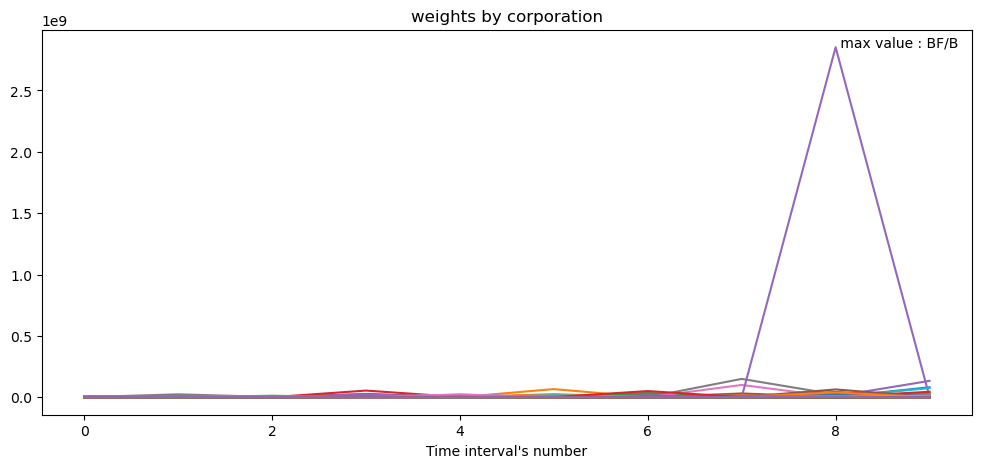

In [73]:
ax=dfweights.plot(legend=False,title='weights by corporation',figsize=(12,5))
ax.text(8,dfweights.max(axis=0).max()," max value : "+f"{dfweights.max(axis=0).idxmax()}")
ax.set_xlabel("Time interval's number")